In [1]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader, BatchLoader, SingleLoader
from importlib import reload
import winsound
import dill, wandb
import datetime as dt
wandblog=0
if wandblog:
    !wandb login b5b917a9390932e56fccfcbff6f528ccd85c44bf
run_counter=0

Notebook
GPU detected


In [2]:
tf.__version__, spektral.__version__

('2.4.1', '1.0.3')

In [40]:
################################################
# Setup Deafult Variables                       # 
################################################
learning_rate = 5e-4
batch_size    = 512//4
epochs        = 20
n_data       = 1e4
scenario    = "GAT_test"+str(run_counter)
patience = 20

################################################
# Setup Hyperparameters                        # 
################################################
hidden_states = 'N/A'
forward       = False
dropout       = 'None'
loss_method   = "loss_func_linear_angle"
n_neighbors   = 6 # SKRIV SELV IND

In [41]:
################################################
# Load data                      # 
################################################

import data_load as dl
reload(dl)
graph_data=dl.graph_data
dataset=graph_data(n_data=n_data, restart=1, transform=True)
idx_lists = dataset.index_lists
# Split data
dataset_train = dataset[idx_lists[0]]
dataset_val   = dataset[idx_lists[1]]
dataset_test  = dataset[idx_lists[2]]

loader_train = DisjointLoader(dataset_train, epochs=epochs, batch_size=batch_size) # the different loaders work very very differently, beware
loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)

winsound.Beep(400,300)

Removed and ready to reload
Connecting to db-file
Loading Muons
Reading files
Splitting data to events
   energy_log10  direction_x  direction_y  direction_z
0      2.311812    -0.865731     0.296605    -0.403157
1      3.433424     0.880773    -0.310683    -0.357373
2      2.582473    -0.100173     0.485243    -0.868622
3      2.783172    -0.297639     0.579176    -0.758924
4      2.531798    -0.523105     0.089420    -0.847565
Generating adjacency matrices


C:\Users\chris\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(



Saving dataset
Loading data to memory




In [5]:
from evals import metricsxpos3 as metrics

def test_angle(loader, plot=True):
    '''Function to test and plot performance of Graph DL
    input should be dom pos x,y,z , time, charge(log10)
    target should be energy(log10),zenith angle, azimuthal angle, NOT unit vec 
    '''
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        inputs[0][:, :3] = inputs[0][:, :3] / 1000 #always pay attention to these two normalizations
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()

    energy = y_true[:, 0]
    counts, bins = np.histogram(energy, bins = 10)

    xs = (bins[1:] + bins[: -1]) / 2

    w_energies, u_angles = [], []

    for i in range(len(bins)-1):
        idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

        w, u_angle = metrics(y_true[idx, :], y_reco[idx, :])

        w_energies.append(w)
        u_angles.append(u_angle)

    if plot:
        fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (12, 6))

        for a in ax:
            a_ = a.twinx()
            a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
            a_.set_yscale("log")
            a.set_xlabel("Log Energy")
        
        ax_top = ax

        # Energy reconstruction
        ax_top[0].scatter(xs, w_energies)
        ax_top[0].set_title("Energy Performance")
        ax_top[0].set_ylabel(r"$w(\Delta log(E)$")

        # Angle reconstruction
        ax_top[1].scatter(xs, u_angles)
        ax_top[1].set_title("Angle Performance")
        ax_top[1].set_ylabel(r"$u(\Delta \Omega)$")

        return fig, ax

In [6]:
if wandblog:
    #checks
    wandb.init(project="icecube", name=scenario,entity="chri862z")

    # Declare for log
    wandb.config.hidden_states = hidden_states
    wandb.config.hidden_states = n_data
    wandb.config.forward = forward
    wandb.config.dropout = dropout
    wandb.config.learning_rate = learning_rate
    wandb.config.batch_size = batch_size
    wandb.config.loss_func = loss_method
    wandb.config.n_neighbors = n_neighbors
    wandb.config.optimizer = 'Adam'

In [7]:
################################################
# Load Model and do checks                      # 
################################################
# import models.GCN0 as m
import models.GCN_johann as m
reload(m)
# model=m.GCN0(6)
model=m.model()
# model.compile('adam', 'categorical_crossentropy') ## this is a basic setup with predetermined optimizers and so on

In [8]:
# ################################################
# # Setup functions                            # 
# ################################################
import loss.loss_funcs as loss_funcs
reload(loss_funcs)
loss_func=loss_funcs.loss_funcxpos

def lr_schedule(epochs = epochs, initial = learning_rate, decay = 0.9):
    n = 1
    lr = initial
    yield lr
    while n < 3:
        lr *= 2
        n  += 1
        yield lr
    while True:
        lr *= decay
        n  += 1 
        yield lr


#make functions into tf functions

@tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training = True)
        targets     = tf.cast(targets, tf.float32)
        loss        = loss_func(predictions, targets)
        loss       += sum(model.losses)

    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function(input_signature = loader_test.tf_signature(), experimental_relax_shapes = True)
def test_step(inputs, targets):
    predictions = model(inputs, training = False)
    targets     = tf.cast(targets, tf.float32) 
    out         = loss_func(predictions, targets)

    return predictions, targets, out


def validation(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        inputs[0][:, :3] = inputs[0][:, :3] / 1000
        # inputs[0][:, 3] = inputs[0][:, 3]
        # targets[:, 1:4] = targets[:, 1:4] / 1000
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)
    
    y_reco  = tf.concat(prediction_list, axis = 0)
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32)

    # w_energy, u_pos, u_angle = metrics(y_reco, y_true) #still missing something
    loss, losses = loss_func(y_reco, y_true, re=True)

    return loss, losses, metrics(y_reco, y_true)



opt = Adam(learning_rate)

In [9]:
run_counter+=1
k=0.2
tot_time=0
current_batch = 0
current_epoch = 1
loss          = 0
lowest_loss   = np.inf
early_stop    = 1
early_stop_counter    = 0
pbar0          = tqdm(total = epochs, position = 0, leave = True)
pbar0.set_description(f"Epochbar")
pbar          = tqdm(total = loader_train.steps_per_epoch, position = k, leave = True)
start_time    = time.time()
lr_gen        = lr_schedule(initial=learning_rate)
learning_Rate = next(lr_gen)
cwd = osp.abspath('')
save_path = osp.join(cwd, 'trained_models/'+scenario)
if not osp.isdir(save_path):
    os.makedirs(save_path)
    print('New folder for saving '+scenario+' made')
# Implement saving model archictecture to wandb
for batch in loader_train:
    inputs, targets = batch
    inputs[0][:, :3] = inputs[0][:, :3] / 1000 #normalize position
    out             = train_step(inputs, targets)
    loss           += out
    if current_epoch==1 and current_batch==0:
        model.summary()
    
    current_batch  += 1
    pbar.update(1)
    pbar.set_description(f"Epoch {current_epoch} / {epochs}; Avg_loss: {loss / current_batch:.6f}")
    
    
    if current_batch == loader_train.steps_per_epoch:
        t=time.time() - start_time
        tot_time+=t
        print(f"Epoch {current_epoch} of {epochs} done in {t:.2f} seconds using learning rate: {learning_rate:.2E}")
        print(f"Avg loss of train: {loss / loader_train.steps_per_epoch:.6f}")

        loader_val    = DisjointLoader(dataset_val, epochs = 1,      batch_size = batch_size)
#         val_loss, val_loss_from, val_metric = validation(loader_val)
        val_loss, val_loss_from, val_metric = validation(loader_val)
        if wandblog:
            wandb.log({"Train Loss":      loss / loader_train.steps_per_epoch,
                       "Validation Loss": val_loss, 
                       "Energy metric":   val_metric[0],
                       "Angle metric":    val_metric[1],
                       "Learning rate":   learning_rate})

        print(f"Avg loss of validation: {val_loss:.6f}")
        print(f"Loss from:  Energy: {val_loss_from[0]:.6f} \t Angle: {val_loss_from[1]:.6f} ")
        print(f"Energy: w = {val_metric[0]:.6f} \t Angle: u = {val_metric[1]:.6f}")

        if val_loss < lowest_loss:
            early_stop_counter = 0
            lowest_loss        = val_loss
        else:
            early_stop_counter += 1
        print(f'Early stop counter: {early_stop_counter}/{patience}, lowest loss was {lowest_loss:.6f}')
        if early_stop and (early_stop_counter >= patience):
            model.save(save_path)
            print(f"Stopped training. No improvement was seen in {patience} epochs")
            break

        if current_epoch != epochs:
            pbar          = tqdm(total = loader_train.steps_per_epoch, position = k, leave = True)

        learning_rate = next(lr_gen)
        opt.learning_rate.assign(learning_rate)
        pbar0.update(1)
        time_avg=tot_time/current_epoch
        delta=dt.timedelta(seconds=time_avg*(epochs-current_epoch))
        now = dt.datetime.now()
        then=now+delta
        time_e = then.strftime("%H:%M:%S")
        pbar0.set_description(f"Expect to finish at {time_e}")
#         if current_epoch % 10 == 0:
#             model.save(save_path)
#             print("Model saved")

        loss            = 0
        start_time      = time.time()
        current_epoch  += 1
        current_batch   = 0
winsound.Beep(400,300)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ecc_conv (ECCConv)           multiple                  29696     
_________________________________________________________________
gcn_conv (GCNConv)           multiple                  4096      
_________________________________________________________________
gcn_conv_1 (GCNConv)         multiple                  8192      
_________________________________________________________________
gcn_conv_2 (GCNConv)         multiple                  32768     
_________________________________________________________________
gcn_conv_3 (GCNConv)         multiple                  131072    
_________________________________________________________________
global_max_pool (GlobalMaxPo multiple                  0         
_________________________________________________________________
global_avg_pool (GlobalAvgPo multiple                  0     

Epoch 2 of 20 done in 15.39 seconds using learning rate: 1.00E-03
Avg loss of train: 1.360386
Avg loss of validation: 1.964479
Loss from:  Energy: 1.475179 	 Angle: 0.489301 
Energy: w = 0.767193 	 Angle: u = 39.542778
Early stop counter: 0/20, lowest loss was 1.964479


Epoch 3 of 20 done in 15.37 seconds using learning rate: 2.00E-03
Avg loss of train: 0.428878
Avg loss of validation: 1.310802
Loss from:  Energy: 0.843455 	 Angle: 0.467346 
Energy: w = 0.344097 	 Angle: u = 54.298294
Early stop counter: 0/20, lowest loss was 1.310802


Epoch 4 of 20 done in 15.92 seconds using learning rate: 1.80E-03
Avg loss of train: 0.353238
Avg loss of validation: 0.958921
Loss from:  Energy: 0.643712 	 Angle: 0.315209 
Energy: w = 0.742954 	 Angle: u = 25.159834
Early stop counter: 0/20, lowest loss was 0.958921



Epoch 5 of 20 done in 16.09 seconds using learning rate: 1.62E-03
Avg loss of train: 0.332236
Avg loss of validation: 0.647115
Loss from:  Energy: 0.447747 	 Angle: 0.199368 
Energy: w = 0.337913 	 Angle: u = 18.645412
Early stop counter: 0/20, lowest loss was 0.647115


Epoch 6 of 20 done in 15.29 seconds using learning rate: 1.46E-03
Avg loss of train: 0.288206
Avg loss of validation: 0.426404
Loss from:  Energy: 0.345976 	 Angle: 0.080428 
Energy: w = 0.330333 	 Angle: u = 18.270462
Early stop counter: 0/20, lowest loss was 0.426404






Epoch 7 of 20 done in 15.35 seconds using learning rate: 1.31E-03
Avg loss of train: 0.267355
Avg loss of validation: 0.372085
Loss from:  Energy: 0.324830 	 Angle: 0.047255 
Energy: w = 0.341240 	 Angle: u = 12.188547
Early stop counter: 0/20, lowest loss was 0.372085


Epoch 8 of 20 done in 19.62 seconds using learning rate: 1.18E-03
Avg loss of train: 0.256246
Avg loss of validation: 0.369752
Loss from:  Energy: 0.319182 	 Angle: 0.050570 
Energy: w = 0.401121 	 Angle: u = 11.691351
Early stop counter: 0/20, lowest loss was 0.369752



Epoch 9 of 20 done in 17.53 seconds using learning rate: 1.06E-03
Avg loss of train: 0.248740
Avg loss of validation: 0.357227
Loss from:  Energy: 0.305664 	 Angle: 0.051563 
Energy: w = 0.253460 	 Angle: u = 10.568331
Early stop counter: 0/20, lowest loss was 0.357227


Epoch 10 of 20 done in 14.34 seconds using learning rate: 9.57E-04
Avg loss of train: 0.251676
Avg loss of validation: 0.332230
Loss from:  Energy: 0.284637 	 Angle: 0.047593 
Energy: w = 0.328688 	 Angle: u = 10.894209
Early stop counter: 0/20, lowest loss was 0.332230



Epoch 11 of 20 done in 18.68 seconds using learning rate: 8.61E-04
Avg loss of train: 0.250195
Avg loss of validation: 0.249032
Loss from:  Energy: 0.201535 	 Angle: 0.047496 
Energy: w = 0.220726 	 Angle: u = 10.526876
Early stop counter: 0/20, lowest loss was 0.249032


Epoch 12 of 20 done in 14.43 seconds using learning rate: 7.75E-04
Avg loss of train: 0.246014
Avg loss of validation: 0.244966
Loss from:  Energy: 0.198884 	 Angle: 0.046082 
Energy: w = 0.212982 	 Angle: u = 12.433191
Early stop counter: 0/20, lowest loss was 0.244966



Epoch 13 of 20 done in 18.54 seconds using learning rate: 6.97E-04
Avg loss of train: 0.244503
Avg loss of validation: 0.252264
Loss from:  Energy: 0.206051 	 Angle: 0.046213 
Energy: w = 0.231276 	 Angle: u = 12.406389
Early stop counter: 1/20, lowest loss was 0.244966


Epoch 14 of 20 done in 17.86 seconds using learning rate: 6.28E-04
Avg loss of train: 0.243677
Avg loss of validation: 0.287630
Loss from:  Energy: 0.241807 	 Angle: 0.045824 
Energy: w = 0.271705 	 Angle: u = 11.942137
Early stop counter: 2/20, lowest loss was 0.244966



Epoch 15 of 20 done in 17.67 seconds using learning rate: 5.65E-04
Avg loss of train: 0.244181
Avg loss of validation: 0.259639
Loss from:  Energy: 0.213544 	 Angle: 0.046094 
Energy: w = 0.239195 	 Angle: u = 13.530413
Early stop counter: 3/20, lowest loss was 0.244966


Epoch 16 of 20 done in 19.18 seconds using learning rate: 5.08E-04
Avg loss of train: 0.243887
Avg loss of validation: 0.259435
Loss from:  Energy: 0.212863 	 Angle: 0.046573 
Energy: w = 0.232350 	 Angle: u = 12.632949
Early stop counter: 4/20, lowest loss was 0.244966



Epoch 17 of 20 done in 16.55 seconds using learning rate: 4.58E-04
Avg loss of train: 0.241689
Avg loss of validation: 0.249360
Loss from:  Energy: 0.203243 	 Angle: 0.046117 
Energy: w = 0.231918 	 Angle: u = 11.831816
Early stop counter: 5/20, lowest loss was 0.244966


Epoch 18 of 20 done in 15.22 seconds using learning rate: 4.12E-04
Avg loss of train: 0.240827
Avg loss of validation: 0.243969
Loss from:  Energy: 0.198261 	 Angle: 0.045709 
Energy: w = 0.225717 	 Angle: u = 12.195403
Early stop counter: 0/20, lowest loss was 0.243969



Epoch 19 of 20 done in 19.94 seconds using learning rate: 3.71E-04
Avg loss of train: 0.241699
Avg loss of validation: 0.237136
Loss from:  Energy: 0.190770 	 Angle: 0.046366 
Energy: w = 0.216053 	 Angle: u = 11.179490
Early stop counter: 0/20, lowest loss was 0.237136


Epoch 20 of 20 done in 18.56 seconds using learning rate: 3.34E-04
Avg loss of train: 0.239571
Avg loss of validation: 0.244326
Loss from:  Energy: 0.197904 	 Angle: 0.046422 
Energy: w = 0.220427 	 Angle: u = 11.461608
Early stop counter: 1/20, lowest loss was 0.237136


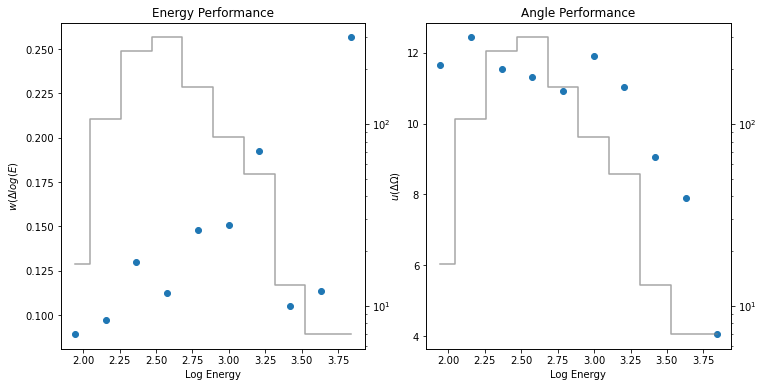

In [10]:
fig, ax = test_angle(loader_test)
if wandblog:
    fig.savefig(f"model_tests/{scenario}_test.pdf")

In [27]:
loader = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
loss = 0
prediction_list, target_list = [], []
for batch in loader:
    inputs, targets = batch
    inputs[0][:, :3] = inputs[0][:, :3] / 1000
    predictions, targets, out = test_step(inputs, targets)
    loss           += out

    prediction_list.append(predictions)
    target_list.append(targets)
y_reco  = tf.concat(prediction_list, axis = 0).numpy()
y_true  = tf.concat(target_list, axis = 0)
y_true  = tf.cast(y_true, tf.float32).numpy()

In [28]:
res=y_reco-y_true

(array([ 2.,  6.,  5.,  6., 14., 17., 22., 25., 23., 28., 24., 23., 26.,
        42., 37., 29., 27., 22., 32., 36., 30., 22., 36., 29., 30., 25.,
        23., 24., 19., 36., 26., 30., 21., 23., 22., 15., 20., 14., 12.,
        13., 11., 13., 11.,  8.,  3., 13.,  8.,  8.,  6.,  3.]),
 array([0.01495625, 0.04316867, 0.07138108, 0.09959349, 0.1278059 ,
        0.15601832, 0.18423073, 0.21244314, 0.24065556, 0.26886797,
        0.2970804 , 0.3252928 , 0.35350522, 0.38171762, 0.40993005,
        0.43814245, 0.46635488, 0.49456728, 0.5227797 , 0.55099213,
        0.5792045 , 0.6074169 , 0.63562936, 0.6638418 , 0.69205415,
        0.7202666 , 0.748479  , 0.77669144, 0.8049038 , 0.83311623,
        0.86132866, 0.8895411 , 0.91775346, 0.9459659 , 0.9741783 ,
        1.0023907 , 1.0306032 , 1.0588156 , 1.0870279 , 1.1152403 ,
        1.1434528 , 1.1716652 , 1.1998776 , 1.22809   , 1.2563025 ,
        1.2845149 , 1.3127272 , 1.3409396 , 1.3691521 , 1.3973645 ,
        1.4255769 ], dtype=float32),

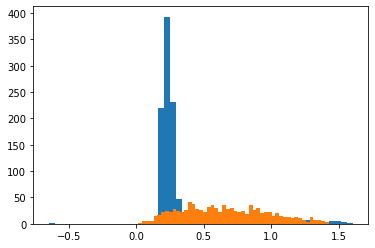

In [44]:
plt.hist(y_reco[:,1], bins=50)
plt.hist(y_true[:,1], bins=50)

In [ ]:
def test(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        inputs[0][:, :3] = inputs[0][:, :3] / 1000
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()


#     # Unit vects to angles
#     reco_vects = normalize(y_reco[:, 1:])    
#     true_vects = normalize(y_true[:, 1:])


#     reco_azi   = np.arctan2(reco_vects[:, 1], reco_vects[:, 0])
#     reco_zen   = np.arctan2(reco_vects[:, 2], np.sqrt((reco_vects[:, :2] ** 2).sum(1)))

#     true_azi   = np.arctan2(true_vects[:, 1], true_vects[:, 0])
#     true_zen   = np.arctan2(true_vects[:, 2], np.sqrt((true_vects[:, :2] ** 2).sum(1)))





    energy = y_true[:, 0]
    counts, bins = np.histogram(energy, bins = 10)

    xs = (bins[1:] + bins[: -1]) / 2

    w_energies, u_angles = [], []

    for i in range(len(bins)-1):
        idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

        w, u_angle = metrics(y_true[idx, :], y_reco[idx, :])

        w_energies.append(w)
        u_angles.append(u_angle)


    fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize = (12, 12))

    for a in ax[0]:
        a_ = a.twinx()
        a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
        a_.set_yscale("log")
        a.set_xlabel("Log Energy")
    
    ax_top = ax[0]

    # Energy reconstruction
    ax_top[0].scatter(xs, w_energies)
    ax_top[0].set_title("Energy Performance")
    ax_top[0].set_ylabel(r"$w(\Delta log(E)$")


    # Angle reconstruction
    ax_top[1].scatter(xs, u_angles)
    ax_top[1].set_title("Angle Performance")
    ax_top[1].set_ylabel(r"$u(\Delta \Omega)$")


    # truth - pred plots
    ax_mid = ax[1]

    # Energy
    ax_mid[0].set_title("Energy")
    ax_mid[0].plot(y_true[:, 0], y_reco[:, 0], 'b.', alpha = 0.25)


    # Zenith
    ax_mid[1].set_title("Zenith angle")
    ax_mid[1].plot(true_zen, reco_zen, 'b.', alpha = 0.25)
    

    # Azimuthal
    ax_mid[2].set_title("Azimuthal angle")
    ax_mid[2].plot(true_azi, reco_azi, 'b.', alpha = 0.25)





    # Histogram of guesses
    ax_bot = ax[2]

    # Energy
    ax_bot[0].set_title("Energy")
    ax_bot[0].hist(y_reco[:, 0] - y_true[:, 0], label = "reco - true", histtype = "step", bins = 50)
    ax_bot[0].hist(y_reco[:, 0], label = "reco", histtype = "step", bins = 50)
    ax_bot[0].hist(y_true[:, 0], label = "true", histtype = "step", bins = 50)

    # Zenith
    ax_bot[1].set_title("Zenith angle")
    ax_bot[1].hist(reco_zen - true_zen, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[1].hist(reco_zen, label = "reco", histtype = "step", bins = 50)
    ax_bot[1].hist(true_zen, label = "true", histtype = "step", bins = 50)

    # Azimuthal
    ax_bot[2].set_title("Azimuthal angle")
    ax_bot[2].hist(reco_azi - true_azi, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[2].hist(reco_azi, label = "reco", histtype = "step", bins = 50)
    ax_bot[2].hist(true_azi, label = "true", histtype = "step", bins = 50)
    ax_bot[2].legend()

    fig.tight_layout()

    return fig, ax

In [16]:
def test(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        inputs[0][:, :3] = inputs[0][:, :3] / 1000
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()


#     # Unit vects to angles
#     reco_vects = normalize(y_reco[:, 1:])    
#     true_vects = normalize(y_true[:, 1:])


#     reco_azi   = np.arctan2(reco_vects[:, 1], reco_vects[:, 0])
#     reco_zen   = np.arctan2(reco_vects[:, 2], np.sqrt((reco_vects[:, :2] ** 2).sum(1)))

#     true_azi   = np.arctan2(true_vects[:, 1], true_vects[:, 0])
#     true_zen   = np.arctan2(true_vects[:, 2], np.sqrt((true_vects[:, :2] ** 2).sum(1)))





    energy = y_true[:, 0]
    counts, bins = np.histogram(energy, bins = 10)

    xs = (bins[1:] + bins[: -1]) / 2

    w_energies, u_angles = [], []

    for i in range(len(bins)-1):
        idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

        w, u_angle = metrics(y_true[idx, :], y_reco[idx, :])

        w_energies.append(w)
        u_angles.append(u_angle)


    fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize = (12, 12))

    for a in ax[0]:
        a_ = a.twinx()
        a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
        a_.set_yscale("log")
        a.set_xlabel("Log Energy")
    
    ax_top = ax[0]

    # Energy reconstruction
    ax_top[0].scatter(xs, w_energies)
    ax_top[0].set_title("Energy Performance")
    ax_top[0].set_ylabel(r"$w(\Delta log(E)$")


    # Angle reconstruction
    ax_top[1].scatter(xs, u_angles)
    ax_top[1].set_title("Angle Performance")
    ax_top[1].set_ylabel(r"$u(\Delta \Omega)$")


    # truth - pred plots
    ax_mid = ax[1]

    # Energy
    ax_mid[0].set_title("Energy")
    ax_mid[0].plot(y_true[:, 0], y_reco[:, 0], 'b.', alpha = 0.25)


    # Zenith
    ax_mid[1].set_title("Zenith angle")
    ax_mid[1].plot(true_zen, reco_zen, 'b.', alpha = 0.25)
    

    # Azimuthal
    ax_mid[2].set_title("Azimuthal angle")
    ax_mid[2].plot(true_azi, reco_azi, 'b.', alpha = 0.25)





    # Histogram of guesses
    ax_bot = ax[2]

    # Energy
    ax_bot[0].set_title("Energy")
    ax_bot[0].hist(y_reco[:, 0] - y_true[:, 0], label = "reco - true", histtype = "step", bins = 50)
    ax_bot[0].hist(y_reco[:, 0], label = "reco", histtype = "step", bins = 50)
    ax_bot[0].hist(y_true[:, 0], label = "true", histtype = "step", bins = 50)

    # Zenith
    ax_bot[1].set_title("Zenith angle")
    ax_bot[1].hist(reco_zen - true_zen, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[1].hist(reco_zen, label = "reco", histtype = "step", bins = 50)
    ax_bot[1].hist(true_zen, label = "true", histtype = "step", bins = 50)

    # Azimuthal
    ax_bot[2].set_title("Azimuthal angle")
    ax_bot[2].hist(reco_azi - true_azi, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[2].hist(reco_azi, label = "reco", histtype = "step", bins = 50)
    ax_bot[2].hist(true_azi, label = "true", histtype = "step", bins = 50)
    ax_bot[2].legend()

    fig.tight_layout()

    return fig, ax

In [17]:
test(loader_test)

IndexError: index 2 is out of bounds for axis 1 with size 2